In [268]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pathlib import Path
from lifelines.utils import concordance_index, survival_table_from_events
from lifelines import CoxPHFitter, AalenAdditiveFitter
from sklearn.preprocessing import MinMaxScaler

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [269]:
LIVER_PATH = Path('/DATA/BIO/GDC/liver')
LIVER_SAMPLES = LIVER_PATH/"samples"
EXP_PATH = LIVER_PATH/"exp_cox"


for d in [EXP_PATH]:
    if not d.exists():
        d.mkdir()

In [270]:
slides = pd.read_csv(LIVER_PATH/'slides.csv')
slides = slides.loc[slides.sample_type_id.isin([1])]
slide_level = 'level_1'
slides['days_proxy'] = slides.days_to_death.fillna(slides.days_to_last_follow_up)
slides = slides.loc[slides.days_proxy.notnull()]
slides['death'] = True
slides.loc[slides.days_to_last_follow_up.notnull(),'death'] = False    
slides['death'] = slides['death'].astype(int)

slides['sec_loc'] = (slides.section_location == 'TOP').astype(int)

features =  [    
    'percent_tumor_nuclei',
    'percent_tumor_cells',
    'percent_normal_cells',
    'age_at_diagnosis',
    'creation_datetime',
    'sec_loc'
]

targets = [
    'days_proxy',
    'death',  
]
scaler = MinMaxScaler()
fit_df = slides.loc[slides.sample_type_id == 1, features+targets].dropna()
fit_df.loc[:,features] = scaler.fit_transform(fit_df[features])


In [271]:
surv_table = survival_table_from_events(fit_df['days_proxy'], fit_df['death'])
print(surv_table.head())


          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             5         0         5       396      396
1.0             1         0         1         0      391
6.0             3         0         3         0      390
8.0             1         0         1         0      387
9.0             3         1         2         0      386


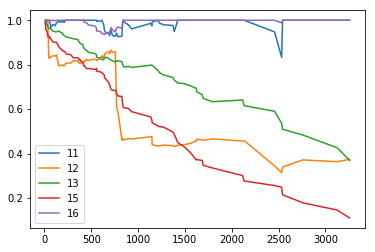

In [272]:
aaf = AalenAdditiveFitter(fit_intercept=False)
aaf.fit(fit_df, 'days_proxy', event_col='death')

X = fit_df.drop(['death', 'days_proxy'], axis=1)
aaf.predict_survival_function(X.iloc[10:15]).plot() 

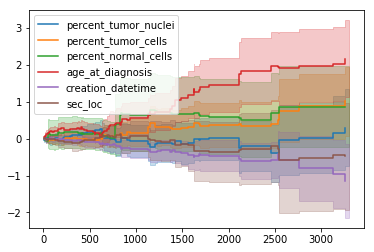

In [273]:
aaf.plot()

In [274]:
model = CoxPHFitter()
model.fit(fit_df, 'days_proxy', event_col='death')

<lifelines.CoxPHFitter: fitted with 396 observations, 289 censored>

In [275]:
model.print_summary()

n=396, number of events=107

                        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
percent_tumor_nuclei -0.5969     0.5505    0.6851 -0.8712 0.3836     -1.9396      0.7458     
percent_tumor_cells  -0.4781     0.6200    0.7031 -0.6799 0.4966     -1.8562      0.9001     
percent_normal_cells  0.3118     1.3659    0.8340  0.3738 0.7085     -1.3229      1.9465     
age_at_diagnosis      1.4463     4.2475    0.6096  2.3725 0.0177      0.2515      2.6412    *
creation_datetime    -1.0272     0.3580    0.2814 -3.6504 0.0003     -1.5787     -0.4757  ***
sec_loc              -0.3805     0.6835    0.3060 -1.2434 0.2137     -0.9802      0.2193     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.657


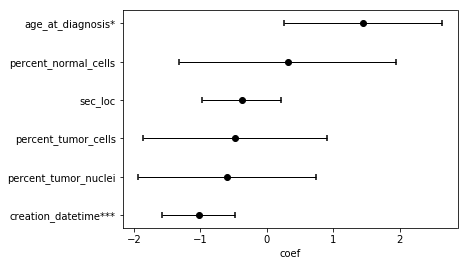

In [276]:
model.plot()

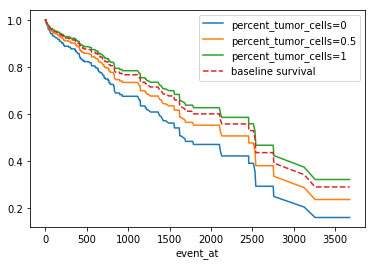

In [277]:
model.plot_covariate_groups('percent_tumor_cells' ,[0,0.5,1])

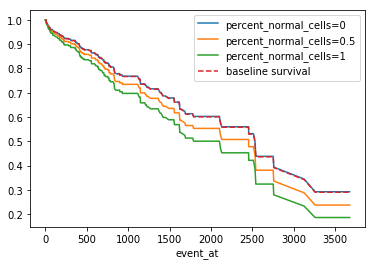

In [278]:
model.plot_covariate_groups('percent_normal_cells' ,[0,0.5,1])

In [279]:
pd.to_datetime(slides.creation_datetime, unit='s').max()

Timestamp('2014-04-10 00:00:00')

In [280]:
slides.columns

Index(['age_at_diagnosis', 'case_id', 'creation_datetime', 'days_to_birth',
       'days_to_death', 'days_to_last_follow_up', 'percent_normal_cells',
       'percent_stromal_cells', 'percent_tumor_cells', 'percent_tumor_nuclei',
       'sample_type', 'sample_type_id', 'section_location', 'slide_file_name',
       'slide_id', 'state', 'submitter_id', 'days_proxy', 'death', 'sec_loc'],
      dtype='object')

In [281]:
(slides['state'] != 'live').sum()

0